In [1]:
from torchvision import datasets
from matplotlib import pyplot as plt
import torch
from torchvision import transforms
import torch.optim as optim
import torch.nn as nn
from matplotlib import pyplot as plt
import numpy as np

data_path = 'C:/Users/keith/Desktop/School/RTAI/HW/HW4'
cifar10 = datasets.CIFAR10(data_path, train=True, download=True) # <1>
cifar10_val = datasets.CIFAR10(data_path, train=False, download=True) # <2>

Files already downloaded and verified
Files already downloaded and verified


In [2]:
len(cifar10)

50000

In [3]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']

img, label = cifar10[99]
img, label, class_names[label]

(<PIL.Image.Image image mode=RGB size=32x32 at 0x22784DFEC70>, 1, 'automobile')

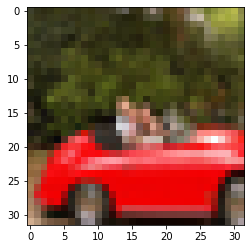

In [4]:
plt.imshow(img)
plt.show()

In [5]:
to_tensor = transforms.ToTensor()
img_t = to_tensor(img)
img_t.shape

torch.Size([3, 32, 32])

In [6]:
tensor_cifar10 = datasets.CIFAR10(data_path, train=True, download=False,
                                 transform=transforms.ToTensor())

In [7]:
img_t, _ = tensor_cifar10[99]
type(img_t)

torch.Tensor

In [8]:
img_t.shape, img_t.dtype

(torch.Size([3, 32, 32]), torch.float32)

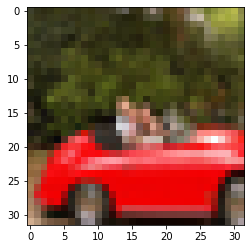

In [9]:
plt.imshow(img_t.permute(1, 2, 0))
plt.show()

In [10]:
imgs = torch.stack([img_t for img_t, _ in tensor_cifar10], dim=3)
imgs.shape

torch.Size([3, 32, 32, 50000])

In [11]:
imgs.view(3, -1).mean(dim=1)

tensor([0.4914, 0.4822, 0.4465])

In [12]:
imgs.view(3, -1).std(dim=1)

tensor([0.2470, 0.2435, 0.2616])

In [13]:
transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))

Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.247, 0.2435, 0.2616))

In [14]:
transformed_cifar10 = datasets.CIFAR10(data_path, train=True, download=False,
                                      transform = transforms.Compose([
                                          transforms.ToTensor(),
                                          transforms.Normalize((0.4914, 0.4822, 0.4465),
                                                               (0.2470, 0.2435, 0.2616))
                                      ]))

transformed_cifar10_val = datasets.CIFAR10(data_path, train=False, download=False,
                                      transform = transforms.Compose([
                                          transforms.ToTensor(),
                                          transforms.Normalize((0.4914, 0.4822, 0.4465),
                                                               (0.2470, 0.2435, 0.2616))
                                      ]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


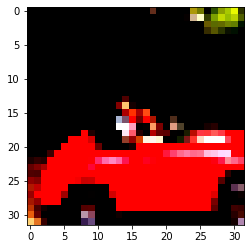

In [15]:
img_t, _ = transformed_cifar10[99]

plt.imshow(img_t.permute(1, 2, 0))
plt.show()

In [16]:
def softmax(x):
    return torch.exp(x) / torch.exp(x).sum()

In [17]:
label_map = {6: 0, 7: 1, 8: 2, 9: 3}
class_names = ['frog','horse','ship','truck']
cifar4 = [(img, label_map[label])
          for img, label in transformed_cifar10 
          if label in [6, 9]]
cifar4_val = [(img, label_map[label])
              for img, label in transformed_cifar10_val
              if label in [6, 9]]

In [18]:
model = nn.Sequential(
            nn.Linear(3072, 512),
            nn.Tanh(),
            nn.Linear(512, 4),
            nn.LogSoftmax(dim=1))

learning_rate = 1e-2
optimizer = optim.SGD(model.parameters(), lr=learning_rate)
loss_fn = nn.NLLLoss()

n_epochs = 200

train_loader = torch.utils.data.DataLoader(cifar4, batch_size=64, shuffle=True)

import time

start = time.time()
for epoch in range(n_epochs):
    for img, label in train_loader:
        
        batch_size = img.shape[0]
        out = model(img.view(batch_size, -1))
        loss = loss_fn(out, label)
                
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    if epoch % 20 == 0 or epoch == 199:
        print("Epoch: %d, Loss: %f" % (epoch, float(loss)))
end = time.time()

ttime = end - start
print(str(ttime) + " seconds")

Epoch: 0, Loss: 0.298331
Epoch: 20, Loss: 0.053050
Epoch: 40, Loss: 0.044491
Epoch: 60, Loss: 0.011122
Epoch: 80, Loss: 0.008501
Epoch: 100, Loss: 0.005278
Epoch: 120, Loss: 0.002632
Epoch: 140, Loss: 0.001872
Epoch: 160, Loss: 0.001338
Epoch: 180, Loss: 0.002150
Epoch: 199, Loss: 0.000711
204.45625805854797 seconds


In [19]:
correct = 0
total = 0

with torch.no_grad():
    for imgs, labels in train_loader:
        batch_size = imgs.shape[0]
        outputs = model(imgs.view(batch_size, -1))
        _, predicted = torch.max(outputs, dim=1)
        total += labels.shape[0]
        correct += int((predicted == labels).sum())
        
print("Accuracy: %f" % (correct / total))

Accuracy: 1.000000


In [20]:
val_loader = torch.utils.data.DataLoader(cifar4_val, batch_size=64,
                                         shuffle=False)

correct = 0
total = 0

with torch.no_grad():
    for imgs, labels in val_loader:
        batch_size = imgs.shape[0]
        outputs = model(imgs.view(batch_size, -1))
        _, predicted = torch.max(outputs, dim=1)
        total += labels.shape[0]
        correct += int((predicted == labels).sum())
        
print("Accuracy: %f" % (correct / total))

Accuracy: 0.913500


In [21]:
numel_list = [p.numel()
              for p in model.parameters()
              if p.requires_grad == True]
sum(numel_list), numel_list

(1575428, [1572864, 512, 2048, 4])